In [12]:
from __future__ import division
import pandas as pd
import sys
from sys import argv
import re
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
def open_bow_df(bow_name):
    
    bow_df_file = pd.read_csv(bow_name, sep = "\t")
    
    return bow_df_file

In [3]:
def split_train_test(bow_df):

    data = bow_df[["Real_ID_x", "Real_ID_y", "Text"]]
    labels = bow_df["Mode"]

    test_s = 0.3 #input("What is the size of test? (0-1, float): ")
    ran_state = 1993 #input("Set random state (int): ")

    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_s, random_state=ran_state)
    data_train, data_test, labels_train, labels_test = data_train.reset_index(drop=True), data_test.reset_index(drop=True), labels_train.reset_index(drop=True), labels_test.reset_index(drop=True) 

    return data_train, data_test, labels_train, labels_test

In [4]:
def texts_to_words( raw_text ):
	# Function to convert a raw text to a string of words
	# The input is a single string (a raw text), and 
	# the output is a single string (a preprocessed text)
	#
	# 2. Remove non-letters        
	letters_only = re.sub("[^a-zA-Z0-9]", " ", raw_text) 
	#
	# 3. Convert to lower case, split into individual words
	words = letters_only.lower().split()                             
	#
	# 4. In Python, searching a set is much faster than searching
	#   a list, so convert the stop words to a set
	stops = set(stopwords.words("english"))                  
	# 
	# 5. Remove stop words
	meaningful_words = [w for w in words if not w in stops]   
	#
	# 6. Join the words back into one string separated by space, 
	# and return the result.
	return( " ".join( meaningful_words ))

In [5]:
def bag_of_words_clean(bow_df):

    data_train, data_test, labels_train, labels_test = split_train_test(bow_df)
    
    # Get the number of reviews based on the dataframe column size
    num_texts = data_train["Text"].size

    # Initialize an empty list to hold the clean reviews
    print "Cleaning and parsing the training set article sentences...\n"
    clean_train_texts = []
    for i in xrange( 0, num_texts ):
        # If the index is evenly divisible by 1000, print a message
        # if( (i+1)%100 == 0 ):
            # print "Texts %d of %d\n" % ( i+1, num_texts )                                                                    
        clean_train_texts.append( texts_to_words( data_train["Text"][i] ))

    num_texts = len(data_test["Text"])
    clean_test_texts = [] 

    print "Cleaning and parsing the test set movie reviews...\n"
    for i in xrange(0,num_texts):
        # if( (i+1) % 1000 == 0 ):
            # print "Review %d of %d\n" % (i+1, num_texts)
        clean_texts = texts_to_words( data_test["Text"][i] )
        clean_test_texts.append( clean_texts )

    return clean_train_texts, clean_test_texts, labels_train, labels_test

In [6]:
bag_of_words_df = open_bow_df("./Bag_of_Words_df.tsv")
clean_train, clean_test, labels_train, labels_test = bag_of_words_clean(bag_of_words_df)

Cleaning and parsing the training set article sentences...

Cleaning and parsing the test set movie reviews...



In [7]:
patterns = [[1, 1, True], [1, 1, False], [1, 2, True], [1, 2, False], 
            [1, 3, True], [1, 3, False],
            [1, 4, True], [1, 4, False], [1, 5, True], [1, 5, False], 
            [2, 3, True], [2, 3, False], [2, 4, True], [2, 4, False],
            [2, 5, True], [2, 5, False], [3, 4, True], [3, 4, False], 
            [3, 5, True], [3, 5, False], [4, 5, True], [4, 5, False]]  

In [8]:
def vectorize_and_transform(c_train, c_test, Param_list, feature_count):
    print "Creating the bag of words...\n"
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.  
    vectorizer = CountVectorizer(analyzer = "word", ngram_range=(Param_list[0], Param_list[1]), token_pattern=r'\b\w+\b', tokenizer = None, preprocessor = None, stop_words = None, max_features = feature_count) 

    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of 
    # strings.
    train_data_features = vectorizer.fit_transform(c_train)

    # Numpy arrays are easy to work with, so convert the result to an 
    # array
    train_data_features = train_data_features.toarray()
    
    test_data_features = vectorizer.transform(c_test)
    test_data_features = test_data_features.toarray()
    # If True then fit_transform to tfidf training data features 
    # and transform test data features to tfidf
    if Param_list[2]:
        print "Doing Tfidf transformation...\n"
        transformer = TfidfTransformer(smooth_idf=False)
        tfidf_train = transformer.fit_transform(train_data_features)
        tfidf_test = transformer.transform(test_data_features)
        tfidf_train = tfidf_train.toarray()
        tfidf_test = tfidf_test.toarray()
        print "Done!"
        return tfidf_train, tfidf_test
    print "Done!"
    return train_data_features, test_data_features

In [18]:
train_f, test_f = vectorize_and_transform(clean_train, clean_test, patterns[6], 10)

Creating the bag of words...

Doing Tfidf transformation...

Done!


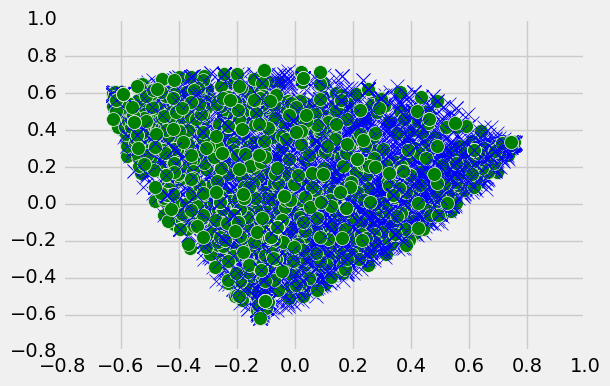

In [19]:
from sklearn import decomposition

pca_auto = decomposition.PCA(n_components = 2)
pca_auto.fit(train_f)
X = pca_auto.transform(train_f)
d = np.matrix(labels_train)
z = np.hstack((X,d.T))
for i in range(z.shape[0]):
    if z[i,2] == 0.0:
        crop = plt.scatter(z[i,0], z[i,1], s=100, c="b", marker = 'x', label = "Crop")
    elif z[i,2] ==1.0:
        weed = plt.scatter(z[i,0], z[i,1], s=100, c="g", marker = 'o', label = "Weed")
plt.show()

In [48]:
logistic = LogisticRegression()
log_reg_parameters = {"solver":("newton-cg", "lbfgs", "liblinear", "sag")}
random_forest = RandomForestClassifier()
ran_for_parameters = {"n_estimators":(100, 200, 300, 400, 500, 1000), "random_state":(23, 23, 23, 23, 23)}

In [49]:
def best_config(model, parameters, train_instances, judgements):
    clf = GridSearchCV(model, parameters, cv=5,
                       scoring="accuracy", n_jobs=4)
    full_result = clf.fit(train_instances, judgements)
    
    return full_result

In [41]:
log_reg_results = best_config(logistic, log_reg_parameters, train_f, labels_train)

In [54]:
ran_for_results = best_config(random_forest, ran_for_parameters, train_f, labels_train)

In [90]:
# TESTS

In [99]:
vectorizer = CountVectorizer(analyzer = "word", ngram_range=(3, 5), token_pattern=r'\b\w+\b', tokenizer = None, preprocessor = None, stop_words = None, max_features = 1000) 
analyze = vectorizer.build_analyzer()

In [100]:
analyze('Bi-grams are cool, and interesting!')

[u'bi grams are',
 u'grams are cool',
 u'are cool and',
 u'cool and interesting',
 u'bi grams are cool',
 u'grams are cool and',
 u'are cool and interesting',
 u'bi grams are cool and',
 u'grams are cool and interesting']

In [79]:
a = pd.DataFrame.from_dict(ran_for_results.best_params_, orient = "index").T

In [80]:
a["Score"] = ran_for_results.best_score_
a["Pattern"] = str(patterns[0])
a = a.set_index("Pattern")

In [87]:
b_d = {"n_estimators": 200, "random_state": 23}
b = pd.DataFrame.from_dict(b_d, orient = "index").T
b["Score"] = 0.758485
b["Pattern"] = str(patterns[1])
b = b.set_index("Pattern")

In [89]:
a = a.append(b)

{'solver': 'liblinear'}

In [96]:
full_lr_result = pd.DataFrame.from_dict(log_reg_results.cv_results_).T
full_lr_result.to_csv("Log_Reg_features_"+str(1000)+"_pattern_"+str(patterns[0])+".tsv", sep = "\t", header = False)